# Training The Miniplaces Dataset with ResNet50

[The miniplaces dataset ](http://6.869.csail.mit.edu/fa17/miniplaces.html) is a subsample of the the [Places2 dataset](http://places2.csail.mit.edu/) (which consists of 10+ million images of palces) consisting of 100,000 images for training, 10,000 images for validation and 10,000 images for testing coming from 100 scene categories. The images are resized to `128*128` to make the data more manageable.


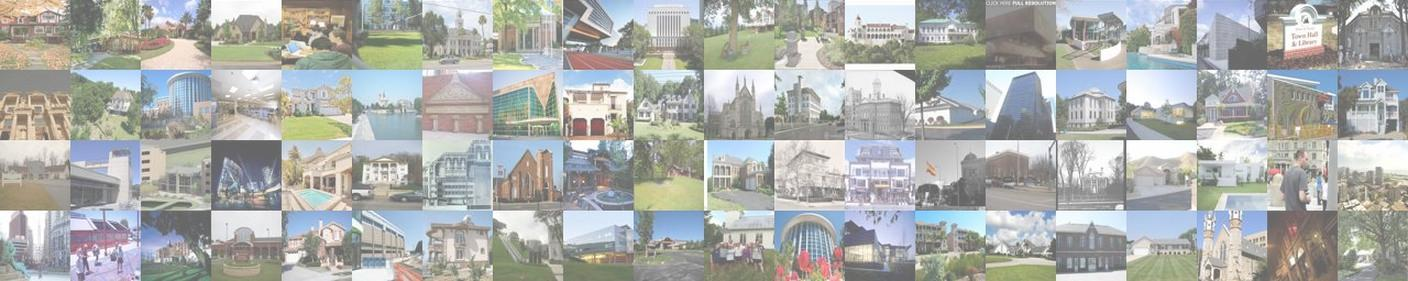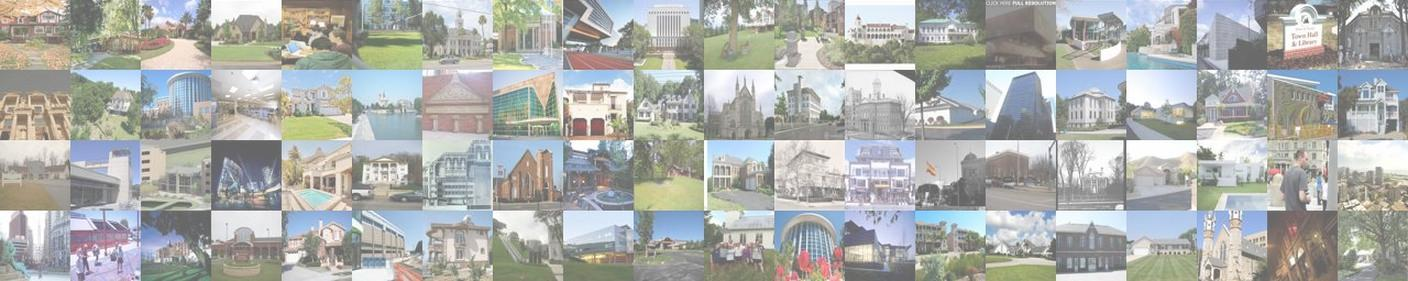

## Setup the environment

In [1]:
import torch
import torchvision
import torchvision.datasets.utils as utils
from sklearn.model_selection import train_test_split

import os
from pathlib import Path
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Download and prepare the datasset.

The [MiniPlaces Dataset](https://github.com/CSAILVision/miniplaces) employs the [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) structure.

-- miniplaces

---- train (1000 images per 100 places)

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002

.

.

-----val

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002

.

.

----test

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002



In [2]:
%%capture

!wget https://dissect.csail.mit.edu/datasets/miniplaces.zip --no-check-certificate && unzip miniplaces.zip

In [3]:
print(f"Total images for validation is: {sum(f.is_file() for f in Path('miniplaces/val').rglob('*'))}\
    \nThis will be split in 70:30 ratio for validation and testing.")

Total images for validation is: 10000    
This will be split in 70:30 ratio for validation and testing.


In [4]:
# utils.download_and_extract_archive('http://dissect.csail.mit.edu/datasets')

# set the path
dataset_path = Path('miniplaces')

val_path = Path('miniplaces/val')

# get classes list
place_names = [dir.name for dir in val_path.iterdir() if dir.is_dir()]

# create test directory
test_path = dataset_path / 'test'
test_path.mkdir(exist_ok=True)

# Now we move some images (30%) from the val folder to test folder
# Iterate over each class
for place in place_names:
    # create place names sub-directories as in val directory to be moved into test directory
    place_dir = val_path.joinpath(place)
    place_images = [image.name for image in place_dir.iterdir() if image.is_file()] # store each image in class_dir in classfiles

    # split the validation set per place folder
    val_images, test_images = train_test_split(place_images, test_size=0.3, random_state=42)

    # create new class directories in test_path
    test_places_dir = test_path.joinpath(place)
    test_places_dir.mkdir(exist_ok=True)

    # move the test file from validation folder to test folder
    for test_image in test_images:
        source = place_dir / test_image
        destination = test_places_dir / test_image
        shutil.move(source, destination)


## Data Augmentation and transformation with Dataset and Dataloader

 - Datasets: Pytorch collection of data
 - ImageFolder: allows to load images directly from the directory structure
 - DataLoader: provides an efficient way to iterate the images during training. Implements the `__get__()` and `__length__()` methods.



__loading structure__: `transform --> datasets.ImageFolder --> DataLoader`

In [5]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

input_size = 128
batch_size = 320
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(input_size), # enusre 128*128
    transforms.RandomHorizontalFlip(),  # Additional data augmentation
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Additional augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Define datasets
train_dataset = ImageFolder(dataset_path / 'train', transform=train_transform)
val_dataset = ImageFolder(val_path, transform=test_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)

# Define data loaders with increased num_workers for faster data loading
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



# train_dataloader, val_dataloader, test_dataloader = preprocess_data(train_data_path=dataset_path / 'train',
#                                                                     val_data_path=dataset_path / 'val',
#                                                                     test_data_path=dataset_path / 'test')

In [6]:
len(train_dataloader)

313

### get a list of all files in all classes

In [7]:
with open('miniplaces/train.txt') as f:
    files_in_class = [file.strip() for file in f.readlines()]

### Display randomly sampled images

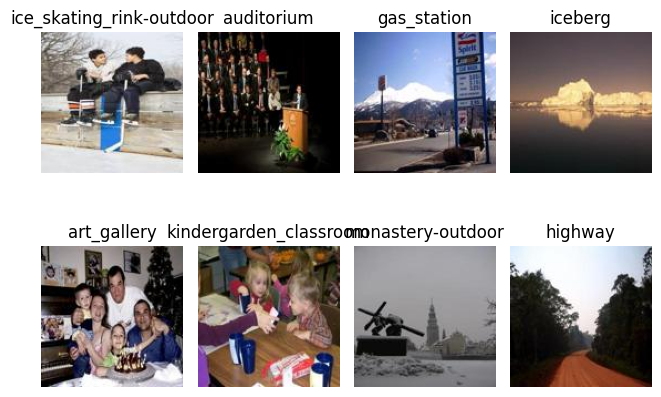

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random


def display_rand_img(n: int):
    
    random_images = random.sample(range(len(files_in_class)), k=n)
    
    fig, axes = plt.subplots(2, n//2, sharex=True, sharey=True)
     
    for i, ax in enumerate(axes.flat):
        sample = random_images[i]
        img_path = os.path.join('miniplaces',files_in_class[sample])
        
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(Path(img_path).parent.stem)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

display_rand_img(8)

## Instantiate a Pretrained Model

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# fetch the pretrained resnet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


In [10]:
import torch.nn as nn

# modify the last layer
num_features = model.fc.in_features # number of input features of the resnet50
num_classes = len(place_names)
model.fc = nn.Linear(in_features=num_features, out_features=num_classes) # createe new output layer with same in_features

## Define Loss Fxn and Optimizer

In [11]:
import torch.nn as nn
import torch.optim as optim

# Loss Function
criterion = nn.CrossEntropyLoss() # combines the softmax activation + neg log likehood loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)


## Create Checkpoint

In [12]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filepath)

## Training Loop

In [13]:
import time

start_time = time.time()
checkpoint_interval = 30


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}')

# move model to GPU
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs for training.')
    model = nn.DataParallel(model)

# Move model to the available device(s)
# model = model.to(device)
model = model.to(device)

# to store losses and accuracies
train_losses = []
train_accuraces = []

epochs = 50
now = 0

# training
for epoch in range(epochs):
  total_losses = 0
  correct = 0
  total = 0

  # set model to training mode
  model.train()

  # iterate over the dataset
  for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)

    # reset the gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(images)

    # calculate loss
    loss = criterion(outputs, labels)

    # backward pass
    loss.backward()

    # update parameters
    optimizer.step()

    # cummulate metrics
    total_losses += loss.item() # loss returns a scalar tensor so use item() method to get the scalar
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  # calculate average metrics
  average_loss = total_losses / len(train_dataloader)
  accuracy = 100.0 * correct / total

  train_losses.append(average_loss)
  train_accuraces.append(accuracy)
    
 # Print training metrics for the current epoch
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, t-{(time.time()-start_time):.0f}s")
    
   # Check if it's time to create a checkpoint
  if time.time() - start_time > checkpoint_interval:
      torch.save(model.state_dict(), f'/kaggle/working/checkpoint_epoch.pth')  # Save the model 
      start_time = time.time()  # Reset start time

Training on device: cuda
Using 2 GPUs for training.
Epoch [1/50], Loss: 2.0311, Accuracy: 46.38%, t-209s
Epoch [2/50], Loss: 1.4800, Accuracy: 58.52%, t-193s
Epoch [3/50], Loss: 1.2849, Accuracy: 63.07%, t-193s
Epoch [4/50], Loss: 1.1492, Accuracy: 66.42%, t-193s
Epoch [5/50], Loss: 1.0418, Accuracy: 69.10%, t-193s
Epoch [6/50], Loss: 0.9419, Accuracy: 71.58%, t-193s
Epoch [7/50], Loss: 0.8618, Accuracy: 73.74%, t-193s
Epoch [8/50], Loss: 0.7827, Accuracy: 75.95%, t-193s
Epoch [9/50], Loss: 0.7162, Accuracy: 77.89%, t-193s
Epoch [10/50], Loss: 0.6550, Accuracy: 79.61%, t-193s
Epoch [11/50], Loss: 0.6096, Accuracy: 80.90%, t-193s
Epoch [12/50], Loss: 0.5567, Accuracy: 82.51%, t-193s
Epoch [13/50], Loss: 0.5166, Accuracy: 83.58%, t-193s
Epoch [14/50], Loss: 0.4788, Accuracy: 84.83%, t-193s
Epoch [15/50], Loss: 0.4497, Accuracy: 85.72%, t-193s
Epoch [16/50], Loss: 0.4285, Accuracy: 86.34%, t-193s
Epoch [17/50], Loss: 0.4049, Accuracy: 87.25%, t-193s
Epoch [18/50], Loss: 0.3805, Accuracy: 

## Visualize Training performance

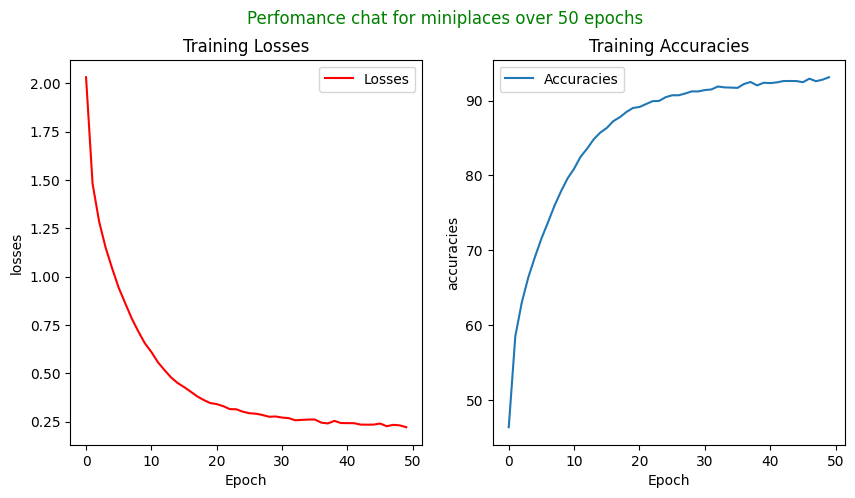

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(train_losses, label='Losses', c='r')
ax1.set(title='Training Losses',
       xlabel='Epoch',
       ylabel='losses')
ax1.legend()


ax2.plot(train_accuraces, label='Accuracies')
ax2.set(title='Training Accuracies',
       xlabel='Epoch',
       ylabel='accuracies')
ax2.legend()

fig.suptitle(f'Perfomance chat for miniplaces over {epochs} epochs\n', fontdict={'color': 'g'})
plt.show()

## Testing and Evaluation

In [15]:
def evaluate_model(model, dataloader):
    model.eval() # evaluation mode
    
    # initialize counters
    total = 0
    correct = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device) # move images to targeted device
            labels = labels.to(device) # move labels to targeted device

            outputs = model(images) # predict labels
            _, predicted = outputs.max(1)
            loss = criterion(outputs, predicted).item()
        
            # count the true positives, predicted positives, and actual positives
            true_positives += torch.logical_and(predicted==1, labels==1).sum().item() #
            predicted_positives += (predicted == 1).sum().item()
            actual_positives += (labels == 1).sum().item()

            # calculate metrics
            total += labels.size(0) # total number of samples
            accuracy = 100.0 * torch.sum(predicted == labels) / total # accuracy = correct / total
            precision = true_positives / predicted_positives # precision = TP / (TP + FP)
            recall = true_positives / actual_positives # recall = TP / (TP + FN)

            return accuracy, precision, recall

accuracy, precision, recall = evaluate_model(model, val_dataloader)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")

Test Accuracy: 55.62%
Test Precision: 1.00
Test Recall: 0.59


Predicted class: amusement_park | Probability: 0.90


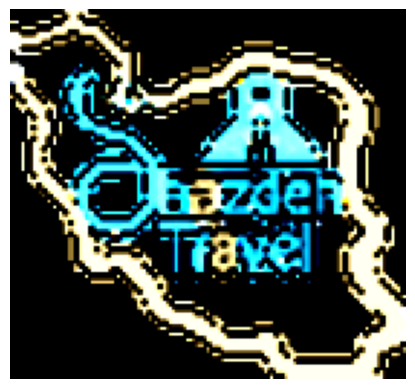


Predicted class: restaurant | Probability: 0.40


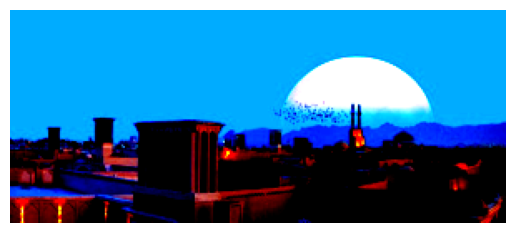


Predicted class: courtyard | Probability: 0.50


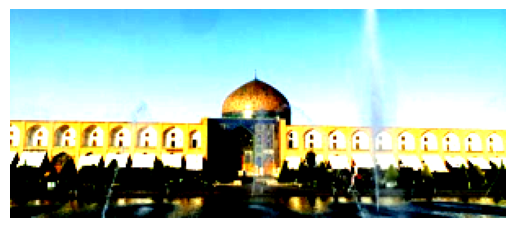


Predicted class: canyon | Probability: 1.00


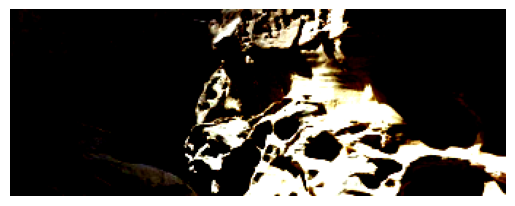


Predicted class: volcano | Probability: 0.73


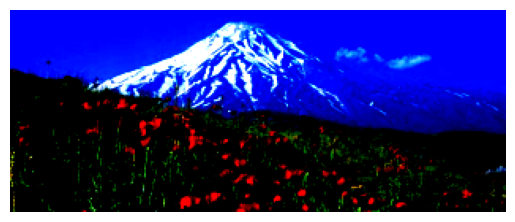


Predicted class: monastery-outdoor | Probability: 0.87


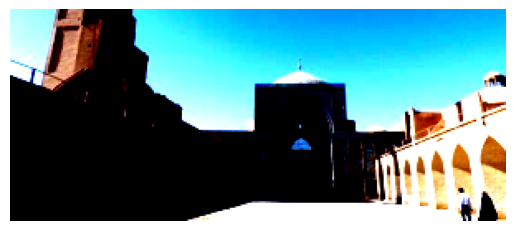


Predicted class: amusement_park | Probability: 0.19


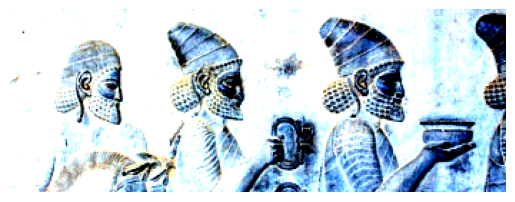


Predicted class: desert-sand | Probability: 1.00


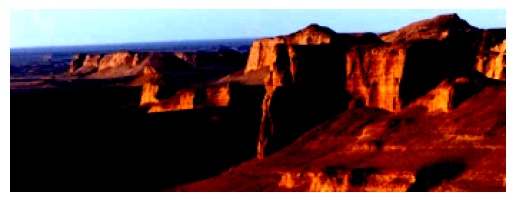


Predicted class: skyscraper | Probability: 0.76


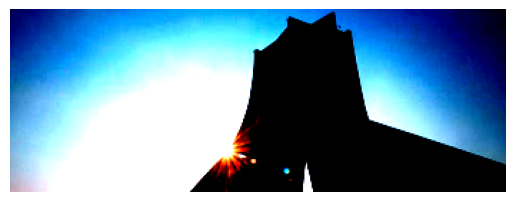


Predicted class: desert-sand | Probability: 0.99


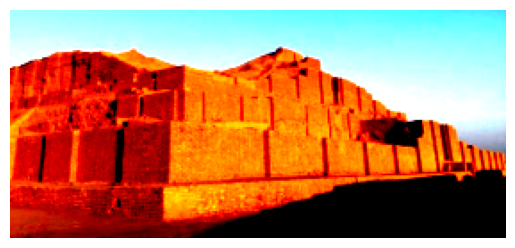


Predicted class: palace | Probability: 0.52


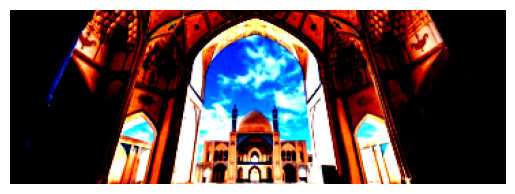


Predicted class: mountain | Probability: 0.88


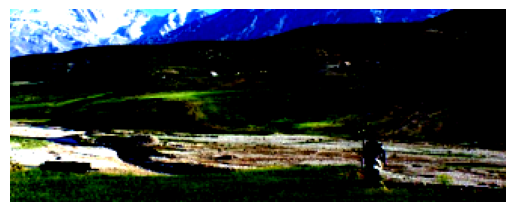

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# Load and process the new image

url = 'https://www.shazdeh-travel.com/iran-travel-guide-2024/best-places-to-visit-in-iran'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'lxml')

images = [img.get('src') for img in soup.find_all('img') if img.get('src') is not None]
    
# fig, axes = plt.subplots(nrows=3, ncols=len(images)//3)

# ax = axes.flat

for i, image in enumerate(images):
    with open('unknown.img', 'wb') as f:
      f.write(requests.get(image).content)

    image_path = 'unknown.img' #'/kaggle/working/miniplaces/val/bamboo_forest/00006502.jpg'#"/kaggle/working/miniplaces/test/lighthouse/00000669.jpg"
    image = Image.open(image_path).convert("RGB")

    # transform new image
    transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    input_image = transform(image).unsqueeze(0).to(device)

#   set model to eval mode
    model.eval()

    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = outputs.max(1)

        probs = nn.functional.softmax(outputs, 1)[0]

        # get predicted class probs
        class_label = predicted.item()
        class_prob = probs[class_label].item()

        print(f"Predicted class: {test_dataloader.dataset.classes[class_label]} | Probability: {class_prob:.2f}")

        plt.imshow(input_image.squeeze().permute(1,2,0).to('cpu'))
        plt.axis('off')
        plt.show()
        print()

## Save model

In [17]:
from joblib import dump, load

dump(model,filename='miniplaces.gz')

['miniplaces.gz']

## Inference Mode